2025-06-08 22:12:31.576 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-08 22:12:31.577 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-08 22:12:31.581 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-08 22:12:31.583 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-08 22:12:33.540 
  command:

    streamlit run C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-06-08 22:12:33.542 Thread 'MainThread': missing ScriptRunContext! This warning ca

DeltaGenerator()

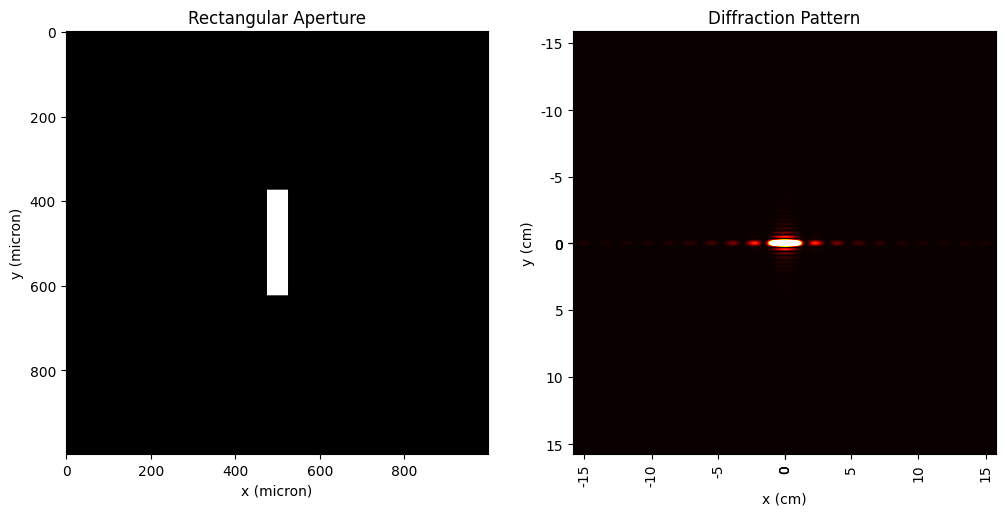

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import streamlit as st

# total pixel number (fixed)
aper_size = 400

#def pixel into metre
experiment_scale_mm = 1e-3
image_scale_pixel = aper_size
metre_per_pixel = experiment_scale_mm / image_scale_pixel
dx = metre_per_pixel
# dx = 2.5 micron per pixel

#set initials variables
#color = 632  # light color in nm
color = st.slider("Wavelength (nm)", 400, 700, 633)
lamda = color*1e-9

#l = 1.25
l = st.slider("Screen Distance (m)", min_value=0.5, max_value=2.0, value=1.25, step=0.05)

#w = 20
w = int(st.slider("Slit Width (micron)", 10.0, 500.0, 50.0, step=2.5)/2.5)
#h = 100
h = int(st.slider("Slit Height (micron)", 10.0, 500.0, 250.0, step=2.5)/2.5)

#zlim = 0.1 # color adjust
zlim = st.slider("Colorscale", 0.01, 0.4, 0.1, step=0.01)

#create rectangular aperture
aperture = np.zeros((aper_size,aper_size))
center = (aper_size//2,aper_size//2)
aperture[center[0]-h//2:center[0]+h//2,center[1]-w//2:center[1]+w//2] = 1

diff = np.fft.fftshift(np.fft.fft2(aperture))
inten = np.abs(diff)**2
phase = np.angle(diff)

fx = np.fft.fftfreq(aper_size, d=dx)
fx = np.fft.fftshift(fx)
x_m = fx * lamda * l  # position on screen of each pixel

#convert pixel into micron
w_m = w * metre_per_pixel
h_m = h * metre_per_pixel
#print("Aperture width in micron:", w_m*1e6)
#print("Aperture height in micron:", h_m*1e6)

diff_spatial = 1 / w_m
diff_x_m = lamda * diff_spatial * l
#print("Distance between diffraction peaks on screen (cm):", diff_x_m*100)
st.markdown("Distance between diffraction peaks on screen (cm): "+str(diff_x_m*100))

# Plot

# find closest indices to match 5 cm intervals
x_cm = x_m * 100  # Convert x from m to cm
target_values = []
target_values_pos = np.arange(0, np.max(x_cm), 5)
for i in range(len(target_values_pos)):
  target_values.append(int(-target_values_pos[-i]))
target_values.append(0)
for i in range(len(target_values_pos)):
  target_values.append(int(target_values_pos[i]))
# Create an empty list to store the closest indices
closest_indices = []
for value in target_values:
  # Find the index of the element in x_cm closest to the target value
  closest_index = np.abs(x_cm - value).argmin()
  closest_indices.append(closest_index)

# Create the figure
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# ---- Subplot 1: Rectangular Aperture ----
axs[0].imshow(aperture, cmap='gray')

xticks = np.arange(0, aper_size, int(aper_size/5))
xticklabels = (np.arange(0, aper_size*metre_per_pixel*1e6, 0.2*aper_size*metre_per_pixel*1e6)).astype(int)
axs[0].set_xticks(xticks)
axs[0].set_xticklabels(xticklabels)

yticks = np.arange(0, aper_size, int(aper_size/5))
yticklabels = (np.arange(0, aper_size*metre_per_pixel*1e6, 0.2*aper_size*metre_per_pixel*1e6)).astype(int)
axs[0].set_yticks(yticks)
axs[0].set_yticklabels(yticklabels)

axs[0].set_xlabel('x (micron)')
axs[0].set_ylabel('y (micron)')
axs[0].set_title('Rectangular Aperture')

# ---- Subplot 2: Diffraction Pattern ----
target_values = list(-np.flip(np.arange(0, np.max(x_cm), 5)).astype(int)) + \
                [0] + list(np.arange(0, np.max(x_cm), 5).astype(int))

closest_indices = [np.abs(x_cm - val).argmin() for val in target_values]

axs[1].imshow(inten / np.max(inten), cmap='hot')
axs[1].set_xticks(closest_indices)
axs[1].set_xticklabels(target_values, rotation=90)
axs[1].set_yticks(closest_indices)
axs[1].set_yticklabels(target_values)
axs[1].set_xlabel('x (cm)')
axs[1].set_ylabel('y (cm)')
axs[1].set_title('Diffraction Pattern')
im = axs[1].imshow(inten / np.max(inten), cmap='hot')
im.set_clim((0, zlim))

# ---- Streamlit Display ----
st.pyplot(fig)
